In [52]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import polars as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings("ignore")

# Data

In [4]:
subpath = "/home/onyxia/work/AML/data/"
weights = pl.read_parquet(subpath + "weights.parquet")
target = pl.read_parquet(subpath + "target.parquet")
responders = pl.read_parquet(subpath + "responders.parquet")
features = pl.read_parquet(subpath + "features.parquet")

# Architecture

## MLP Buider

In [5]:
def make_mlp(widths, activation=nn.ReLU):
    """
    widths : [in_dim, h1, h2, ..., out_dim]
    """
    layers = []
    for in_f, out_f in zip(widths[:-1], widths[1:]):
        layers.append(nn.Linear(in_f, out_f))
        layers.append(activation())
    layers.pop()  # retire la dernière activation inutile
    return nn.Sequential(*layers)


## Auto-Encoder supervised & unsupervised

In [6]:
class Encoder(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, z):
        return self.net(z)


class TaskHead(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, z):
        return self.net(z)


## Build up

In [7]:
class FullModel(nn.Module):
    def __init__(self,
                 encoder_widths,   # ex : [input_dim, 256, 128, latent_dim]
                 decoder_widths,   # ex : [latent_dim, 128, 256, input_dim]
                 head_widths       # ex : [latent_dim, 64, output_dim]
                ):
        super().__init__()

        self.encoder = Encoder(encoder_widths)
        self.decoder = Decoder(decoder_widths)
        self.head = TaskHead(head_widths)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        y_hat = self.head(z)
        return z, x_hat, y_hat


## Utils

In [8]:
def r2_loss(y_true, y_pred):
    """
    R^2 est calculé via sklearn → numpy nécessaire.
    Loss = 1 - R^2 pour pouvoir backpropager.
    """
    y_t = y_true.detach().cpu().numpy()
    y_p = y_pred.detach().cpu().numpy()
    return 1 - r2_score(y_t, y_p)


In [61]:
def train_model(
    model,
    X_train_t, y_train_t,
    X_test_t, y_test_t,
    n_epochs=60, batch_size=64,
    alpha=1.0, beta=1.0
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # envoyer données sur GPU
    X_train_t = X_train_t.to(device)
    y_train_t = y_train_t.to(device)
    X_test_t  = X_test_t.to(device)
    y_test_t  = y_test_t.to(device)

    n = len(X_train_t)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler()

    r2_rec_test_list = []
    r2_sup_test_list = []
    loss_list = []

    for epoch in range(n_epochs):

        perm = torch.randperm(n, device=device)
        total_loss = 0.0

        # -------------------------
        #   TRAIN LOOP
        # -------------------------
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb = X_train_t[idx]
            yb = y_train_t[idx]

            optimizer.zero_grad()

            with autocast():
                z, x_hat, y_hat = model(xb)

                loss_rec = F.mse_loss(x_hat, xb)
                loss_sup = F.mse_loss(y_hat, yb)
                loss = alpha * loss_rec + beta * loss_sup

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        # -------------------------
        #   R² SUR LE TEST SET
        # -------------------------
        with torch.no_grad():
            _, x_hat_test, y_hat_test = model(X_test_t)

        # convertir vers CPU + numpy
        r2_rec_test = r2_score(X_test_t.cpu().numpy(),
                               x_hat_test.cpu().numpy())
        r2_sup_test = r2_score(y_test_t.cpu().numpy(),
                               y_hat_test.cpu().numpy())

        r2_rec_test_list.append(r2_rec_test)
        r2_sup_test_list.append(r2_sup_test)
        loss_list.append(total_loss)

        print(
            f"Epoch {epoch+1:02d} | loss={total_loss:.3f} "
            f"| R2_rec_test={r2_rec_test:.4f} "
            f"| R2_sup_test={r2_sup_test:.4f}"
        )

    return r2_rec_test_list, r2_sup_test_list, loss_list


In [ ]:
def plot_r2(r2_rec_list, r2_sup_list):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # --- subplot 1 : reconstruction ---
    axes[0].plot(r2_rec_list, color="tab:blue")
    axes[0].set_ylabel("R² (reconstruction)")
    axes[0].set_title("Évolution du R² reconstruction")
    axes[0].grid(True)

    # --- subplot 2 : supervision ---a
    axes[1].plot(r2_sup_list, color="tab:green")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("R² (supervision)")
    axes[1].set_title("Évolution du R² supervision")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()



# Train simulated data

In [11]:
# Génération données simulées
n = 2000
d = 20

X = np.random.randn(n, d).astype(np.float32)
y = (X[:, :5].sum(axis=1) + 0.1*np.random.randn(n)).astype(np.float32).reshape(-1, 1)

X_t = torch.tensor(X)
y_t = torch.tensor(y)


In [12]:
input_dim = 20
latent_dim = 19
output_dim = 1

model = FullModel(
    encoder_widths=[input_dim, 64, 32, latent_dim],
    decoder_widths=[latent_dim, 32, 64, input_dim],
    head_widths=[latent_dim, 32, output_dim]
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Epoch 01 | loss=181.504 | R2_rec=0.0097 | R2_sup=0.2078
Epoch 02 | loss=98.951 | R2_rec=0.0542 | R2_sup=0.8942
Epoch 03 | loss=40.460 | R2_rec=0.0804 | R2_sup=0.9669
Epoch 04 | loss=33.223 | R2_rec=0.1165 | R2_sup=0.9805
Epoch 05 | loss=30.631 | R2_rec=0.1383 | R2_sup=0.9876
Epoch 06 | loss=29.028 | R2_rec=0.1756 | R2_sup=0.9908
Epoch 07 | loss=27.281 | R2_rec=0.2142 | R2_sup=0.9925
Epoch 08 | loss=25.931 | R2_rec=0.2491 | R2_sup=0.9937
Epoch 09 | loss=24.714 | R2_rec=0.2832 | R2_sup=0.9942
Epoch 10 | loss=23.619 | R2_rec=0.3152 | R2_sup=0.9939
Epoch 11 | loss=22.626 | R2_rec=0.3418 | R2_sup=0.9946
Epoch 12 | loss=21.691 | R2_rec=0.3663 | R2_sup=0.9945
Epoch 13 | loss=20.896 | R2_rec=0.3867 | R2_sup=0.9953
Epoch 14 | loss=20.246 | R2_rec=0.4021 | R2_sup=0.9957
Epoch 15 | loss=19.830 | R2_rec=0.4161 | R2_sup=0.9960
Epoch 16 | loss=19.328 | R2_rec=0.4284 | R2_sup=0.9959
Epoch 17 | loss=18.742 | R2_rec=0.4412 | R2_sup=0.9960
Epoch 18 | loss=18.476 | R2_rec=0.4528 | R2_sup=0.9960
Epoch 19 

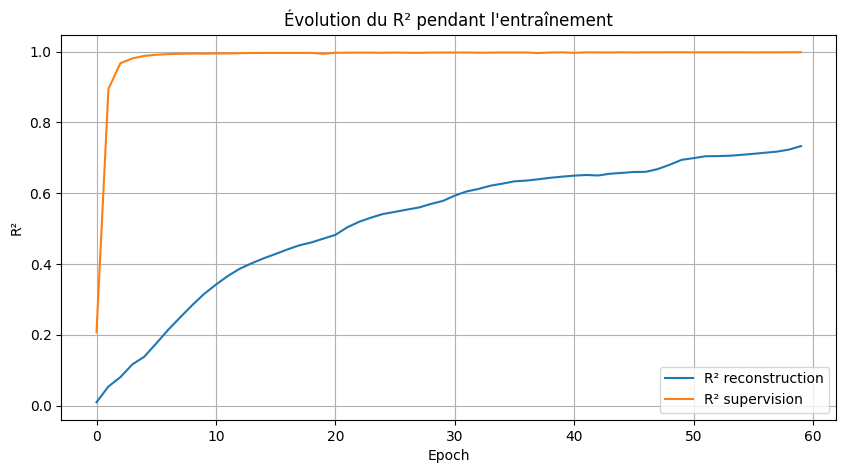

In [13]:
r2_rec_list, r2_sup_list, loss_list = train_model(
    model,
    X_t,
    y_t,
    n_epochs=60,
    batch_size=64,
    alpha=1.0,
    beta=1.0
)

plot_r2(r2_rec_list, r2_sup_list)


# Train real data

In [ ]:
n = features.height
n_train = int(0.8 * n)

X_train = features.slice(0, n_train)
y_train = target.slice(0, n_train)

X_test = features.slice(n_train)
y_test = target.slice(n_train)

X_train_t = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_t = torch.tensor(y_train.to_numpy().reshape(-1,1), dtype=torch.float32)

X_test_t  = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_t  = torch.tensor(y_test.to_numpy().reshape(-1,1), dtype=torch.float32)

input_dim = X_train_t.shape[1]
latent_dim = 10
output_dim = 1
lr = 1e-3

model = FullModel(
    encoder_widths=[input_dim, 64, 32, latent_dim],
    decoder_widths=[latent_dim, 32, 64, input_dim],
    head_widths=[latent_dim, 32, output_dim]
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

r2_rec_test, r2_sup_test, losses = train_model(
    model,
    X_train_t, y_train_t,
    X_test_t, y_test_t,
    n_epochs=30,
    batch_size=512
)

Epoch 01 | loss=6596.776 | R2_rec_test=-0.6329 | R2_sup_test=-0.0109
Epoch 02 | loss=1632.881 | R2_rec_test=-0.2771 | R2_sup_test=-0.0032
